In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


nbPicture = 0

dataDirectory = '/kaggle/input/radiolarian-images/Radiolarian images' #replace by the directory of your images

import os
for dirname, _, filenames in os.walk(dataDirectory):
    for filename in filenames:
        nbPicture += 1
print (nbPicture)

1087


We have checked the number of picture avaible, now let's go into the structure.

We then just compile the model with the right metrics and accuracy regarding the representation of the classes we have chosen (a vectorial one).

In [2]:
import gc
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


from matplotlib.collections import QuadMesh
from pandas import DataFrame
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model


target_size = 160

def build_model( ):
    input_tensor = Input(shape=(160, 160, 3))
    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=7, input_shape=(160, 160, 3), activation = 'relu')(
        input_tensor)
    
    x = tf.keras.layers.Conv2D(filters=64, strides = 2, kernel_size=7, input_shape=(154, 154, 32), activation = 'relu')(
        x)
    
    x = tf.keras.layers.MaxPooling2D(strides = 1, pool_size=(2,2), padding = 'same', input_shape=(74, 74, 64))(
        x)
    
    x = tf.keras.layers.Conv2D(filters=128, strides = 2, kernel_size=7, input_shape=(74, 74, 64), activation = 'relu')(
        x)

    x = tf.keras.layers.Conv2D(filters = 256, strides = 2, kernel_size=5, input_shape=(34, 34, 128), activation = 'relu')(
        x)
    
    
    x = tf.keras.layers.Flatten()(x)


        
    output_tensor = Dense(8, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    
    
    return model
    
    
from tensorflow.keras.optimizers import Adam


model = build_model()
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


Here, we load the data from the Kaggle dataset that I've uploaded. Then, we split the data into a train set and a test set (85/15).

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

batchSize = 64

# Load the train data and test data

train_data_dir = dataDirectory


train_datagen = ImageDataGenerator()
itr = train_datagen.flow_from_directory(
train_data_dir,
target_size=(target_size, target_size),
batch_size=nbPicture,
class_mode='categorical')

label_map = (itr.class_indices)

X, y = itr.next()

print("X shape = ", X.shape)
print("y shape = ", y.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    
print("x_train shape = ", x_train.shape)
print("x_test shape = ", x_test.shape)
print("y_train shape = ", y_train.shape)
print("y_test shape = ", y_test.shape)
    

Found 1087 images belonging to 8 classes.
X shape =  (1087, 160, 160, 3)
y shape =  (1087, 8)
x_train shape =  (923, 160, 160, 3)
x_test shape =  (164, 160, 160, 3)
y_train shape =  (923, 8)
y_test shape =  (164, 8)


The preprocess_images is the function taking as input a dataset and return the same dataset, but fitting the prerequisites of the model we have created. We take care of the format of our data, checking wether it has 3 or 4 dimensions, and if the images are in grayscale or in a rgb format.

In [4]:
from sklearn.utils import shuffle
from tensorflow.image import resize, grayscale_to_rgb
    
    
def preprocess_images(x):

    batch = preprocess_input(x)
    if (len(x.shape)==3):
        batch = batch[..., np.newaxis]

    if (x.shape[3]==1):  
        batch = grayscale_to_rgb(tf.convert_to_tensor(batch))
        
    batch = resize(batch, (target_size, target_size))
    batch = np.asarray(batch)

           
    return (tf.convert_to_tensor(batch.astype(np.float32)))    

In [5]:
norm_x_train = preprocess_images(x_train)

del x_train
gc.collect()
    
train_dataset = tf.data.Dataset.from_tensor_slices((norm_x_train, y_train)).shuffle(norm_x_train.shape[0], reshuffle_each_iteration=True).batch(batchSize).repeat(70)
    
    
del norm_x_train
del y_train
gc.collect()


    
model.fit(
        train_dataset,
        batch_size = batchSize,
        steps_per_epoch=100,
        verbose=1,
        epochs=3)
    

model.save("/kaggle/working/mobilenet_radiolarians") #replace the address by the one where you want to save the trained model

    
del train_dataset
gc.collect()

Epoch 1/3
100/100 [==============================] - 17s 93ms/step - loss: 1.7072 - categorical_accuracy: 0.4780
Epoch 2/3
100/100 [==============================] - 9s 89ms/step - loss: 0.0931 - categorical_accuracy: 0.9685
Epoch 3/3
100/100 [==============================] - 9s 89ms/step - loss: 0.0055 - categorical_accuracy: 0.9974


6265

In [6]:
# Reference for this part : https://github.com/wcipriano/pretty-print-confusion-matrix



def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')


def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()



10/10 [==============================] - 1s 44ms/step
Podocyrtis ampla  :  0.8333333333333334  (for  6.0  elements).
Podocyrtis chalara  :  0.9130434782608695  (for  23.0  elements).
Podocyrtis diamesa  :  0.5555555555555556  (for  18.0  elements).
Podocyrtis goetheana  :  0.9411764705882353  (for  17.0  elements).
Podocyrtis mitra  :  0.8333333333333334  (for  36.0  elements).
Podocyrtis papalis  :  0.9555555555555556  (for  45.0  elements).
Podocyrtis phyxis  :  0.7272727272727273  (for  11.0  elements).
Podocyrtis sinuosa  :  0.75  (for  8.0  elements).
Accuracy based on the evaluation by class :  0.8475609756097561
10/10 [==============================] - 1s 31ms/step - loss: 1.0351 - categorical_accuracy: 0.8381


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


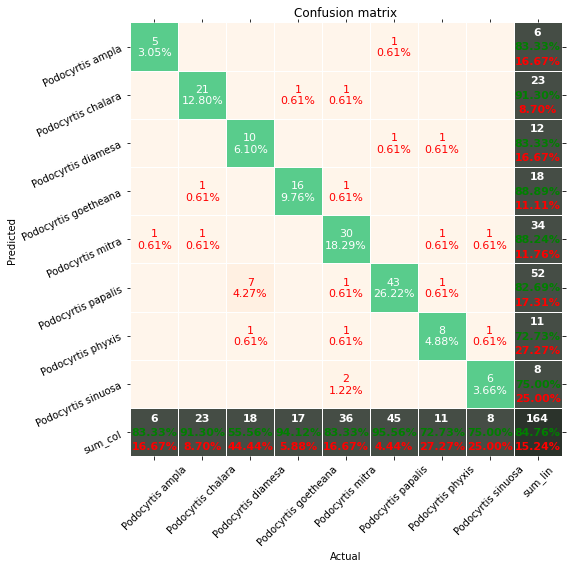

In [7]:
norm_x_test = preprocess_images(x_test)

y_pred = model.predict(x_test, batch_size = batchSize, verbose = 1,use_multiprocessing = True, steps = 10)

y_test = np.asarray(y_test)
y_pred = np.asarray(y_pred)



def acc_by_class(pred, true):
    avg = 0
    acc = np.zeros(8)
    num_per_class = np.zeros(8)
    assert pred.shape == true.shape
    n = pred.shape[0]
    for i in range(n):
        ref = true[i]
        maxInd = np.argmax(ref)
        num_per_class[maxInd] += 1
        if maxInd == np.argmax(pred[i]):
            acc[maxInd] += 1
            avg += 1
    for k in range(8):
        acc[k] /= num_per_class[k]
    avg /= n    
    return acc , num_per_class , avg

predAcc, class_size , avg = acc_by_class(y_pred, y_test)


for i in range(8):
    print(list(label_map.items())[i][0], " : ", predAcc[i], " (for ", class_size[i],  " elements).")
    
print("Accuracy based on the evaluation by class : ", avg)




val_y_test = np.argmax(np.asarray(y_test), axis = 1)
val_y_pred = np.argmax(np.asarray(y_pred), axis = 1)



confMat = tf.math.confusion_matrix (labels = val_y_test, predictions = val_y_pred, num_classes = 8).numpy()

df_cm = pd.DataFrame(confMat, index = np.asarray(list(label_map.items()))[:, 0],
                  columns = np.asarray(list(label_map.items()))[:, 0])




test_dataset = tf.data.Dataset.from_tensor_slices((norm_x_test, y_test)).shuffle(norm_x_test.shape[0], reshuffle_each_iteration=True).batch(batchSize).repeat(10)

del norm_x_test
del y_test
gc.collect()


    
model.evaluate(
        test_dataset,
        steps=10,
        verbose=1)


pretty_plot_confusion_matrix(df_cm)